# Load Data

In [14]:
import pandas as pd
import platform
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from datetime import timedelta
from collections import defaultdict
import joblib
import json
import warnings
import time
from scipy.stats.mstats import winsorize
import numba
import pandas_ta as pta

import sys
import os

# Add one directory up to sys.path
sys.path.append(os.path.abspath(".."))

# Internal Libraries
from data_loader import load_and_resample_data, apply_feature_engineering
from backtest import evaluate_regression
from labeling_utils import label_and_save
from helpers import check_overfit, generate_oof_predictions, is_same_session
#

# Tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler, RobustScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber, MeanSquaredError
import tensorflow as tf
#

# Scikit-learn
from sklearn.base import clone, BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier, ElasticNet, Ridge
from sklearn.metrics import classification_report, root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score, \
    confusion_matrix, precision_recall_curve, roc_curve, auc, accuracy_score, classification_report, f1_score, precision_score, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize, StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight

# Models and Training
from catboost import CatBoostRegressor, CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb
import optuna
import seaborn as sns
import shap
from sklearn.svm import SVC
#

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", message=".*There are no meaningful features.*", category=UserWarning)
optuna.logging.set_verbosity(optuna.logging.INFO)

# Initialize features or indicators

In [15]:
# This is your Cell 5: Feature Engineering Function Definitions

# --- Helper Functions for Custom Features (Some will be kept, some modified/called differently) ---
# These helpers now expect columns to be named as pandas_ta typically names them (e.g., RSI_14, EMA_10, MACD_12_26_9, etc.)

def add_price_vs_ma(df, price_col='close', ma_col_name='EMA_20', new_col_name_suffix='_vs_EMA20'):
    # Ensure ma_col_name exists (it would have been created by pandas_ta)
    if ma_col_name in df.columns and price_col in df.columns:
        # Ensure inputs are numeric before division
        df[price_col + new_col_name_suffix] = pd.to_numeric(df[price_col], errors='coerce') / pd.to_numeric(df[ma_col_name], errors='coerce')
    return df

def add_ma_vs_ma(df, ma1_col_name='EMA_10', ma2_col_name='EMA_20', new_col_name_suffix='_vs_EMA20'):
    if ma1_col_name in df.columns and ma2_col_name in df.columns:
        df[ma1_col_name + new_col_name_suffix] = pd.to_numeric(df[ma1_col_name], errors='coerce') / pd.to_numeric(df[ma2_col_name], errors='coerce')
    return df

def add_ma_slope(df, ma_col_name='EMA_10', new_col_name_suffix='_Slope_10', periods=1):
    if ma_col_name in df.columns:
        df[new_col_name_suffix] = pd.to_numeric(df[ma_col_name], errors='coerce').diff(periods) / periods
    return df

def add_rsi_signals(df, rsi_col_name='RSI_14', ob_level=70, os_level=30):
    if rsi_col_name in df.columns:
        rsi_series = pd.to_numeric(df[rsi_col_name], errors='coerce')
        df[rsi_col_name + f'_Is_Overbought_{ob_level}'] = (rsi_series > ob_level).astype(int)
        df[rsi_col_name + f'_Is_Oversold_{os_level}'] = (rsi_series < os_level).astype(int)
    return df

def add_stoch_signals(df, stoch_k_col_name='STOCHk_14_3_3', ob_level=80, os_level=20): # Default pandas_ta name for k
    if stoch_k_col_name in df.columns:
        stoch_k_series = pd.to_numeric(df[stoch_k_col_name], errors='coerce')
        df[stoch_k_col_name + f'_Is_Overbought_{ob_level}'] = (stoch_k_series > ob_level).astype(int)
        df[stoch_k_col_name + f'_Is_Oversold_{os_level}'] = (stoch_k_series < os_level).astype(int)
    return df

def add_macd_cross_signal(df, macd_col_name='MACD_12_26_9', signal_col_name='MACDs_12_26_9'): # Default pandas_ta name for signal
    if macd_col_name in df.columns and signal_col_name in df.columns:
        macd_series = pd.to_numeric(df[macd_col_name], errors='coerce')
        signal_series = pd.to_numeric(df[signal_col_name], errors='coerce')
        crossed_above = (macd_series > signal_series) & (macd_series.shift(1) < signal_series.shift(1))
        crossed_below = (macd_series < signal_series) & (macd_series.shift(1) > signal_series.shift(1))
        df[macd_col_name + '_Cross_Signal'] = np.where(crossed_above, 1, np.where(crossed_below, -1, 0))
    return df

def add_price_vs_bb(df, price_col='close', bb_upper_col='BBU_20_2.0', bb_lower_col='BBL_20_2.0'): # Default pandas_ta names
    if price_col in df.columns and bb_upper_col in df.columns and bb_lower_col in df.columns:
        price_series = pd.to_numeric(df[price_col], errors='coerce')
        bb_upper_series = pd.to_numeric(df[bb_upper_col], errors='coerce')
        bb_lower_series = pd.to_numeric(df[bb_lower_col], errors='coerce')
        df[price_col + '_vs_BB_Upper'] = (price_series > bb_upper_series).astype(int)
        df[price_col + '_vs_BB_Lower'] = (price_series < bb_lower_series).astype(int)
    return df

def add_psar_flip_signal(df, psar_col_name='PSARr_0.02_0.2', close_col='close'): # pandas_ta PSAR reversal column
    if psar_col_name in df.columns: # PSARr is 1 for reversal to uptrend, -1 for reversal to downtrend
        df['PSAR_Flip_Signal'] = pd.to_numeric(df[psar_col_name], errors='coerce').fillna(0).astype(int)
    return df

# Keep these custom functions as they are generally good:
def add_daily_vwap(df, high_col='high', low_col='low', close_col='close', volume_col='volume', new_col_name='VWAP_D'): # Changed name to VWAP_D for daily
    # ... (your existing robust add_daily_vwap function - ensure it uses .copy() and numeric conversions internally)
    # Make sure the final column is named VWAP_D or adjust add_price_vs_ma call later
    if not isinstance(df.index, pd.DatetimeIndex):
        print("Error: DataFrame index must be DatetimeIndex for daily VWAP.")
        return df
    df_temp = df.copy()
    for col in [high_col, low_col, close_col, volume_col]:
        df_temp[col] = pd.to_numeric(df_temp[col], errors='coerce')
    tpv = ((df_temp[high_col] + df_temp[low_col] + df_temp[close_col]) / 3) * df_temp[volume_col]
    cumulative_tpv = tpv.groupby(df_temp.index.date).cumsum()
    cumulative_volume = df_temp[volume_col].groupby(df_temp.index.date).cumsum()
    vwap_series = cumulative_tpv / cumulative_volume
    df[new_col_name] = vwap_series.replace([np.inf, -np.inf], np.nan)
    return df


def add_candle_features(df):
    # ... (your existing add_candle_features function - ensure numeric conversions) ...
    df_temp = df.copy()
    for col in ['open', 'high', 'low', 'close']:
        df_temp[col] = pd.to_numeric(df_temp[col], errors='coerce')
    df['Candle_Range'] = df_temp['high'] - df_temp['low']
    df['Candle_Body'] = (df_temp['close'] - df_temp['open']).abs()
    df['Upper_Wick'] = df_temp['high'] - np.maximum(df_temp['open'], df_temp['close'])
    df['Lower_Wick'] = np.minimum(df_temp['open'], df_temp['close']) - df_temp['low']
    df['Body_vs_Range'] = (df['Candle_Body'] / df['Candle_Range'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0)
    return df

def add_return_features(df, price_col='close'):
    # ... (your existing add_return_features function - ensure numeric conversions and inf handling) ...
    price_series_num = pd.to_numeric(df[price_col], errors='coerce').replace(0, np.nan)
    df[f'Log_Return_1'] = np.log(price_series_num / price_series_num.shift(1))
    df[f'Log_Return_3'] = np.log(price_series_num / price_series_num.shift(3))
    df[f'Log_Return_6'] = np.log(price_series_num / price_series_num.shift(6))
    df[f'Simple_Return_1'] = price_series_num.pct_change(1)
    for col_ret in [f'Log_Return_1', f'Log_Return_3', f'Log_Return_6', f'Simple_Return_1']:
        if col_ret in df.columns: df[col_ret] = df[col_ret].replace([np.inf, -np.inf], np.nan)
    return df

def add_rolling_stats(df, price_col='close', window1=14, window2=30):
    # ... (your existing add_rolling_stats function - ensure numeric conversions and inf handling) ...
    returns = pd.to_numeric(df[price_col], errors='coerce').pct_change(1).replace([np.inf, -np.inf], np.nan)
    df[f'Rolling_Std_Dev_{window1}'] = returns.rolling(window=window1).std()
    df[f'Rolling_Skew_{window2}'] = returns.rolling(window=window2).skew()
    df[f'Rolling_Kurtosis_{window2}'] = returns.rolling(window=window2).kurt()
    return df

def add_lagged_features(df, cols_to_lag, lags=[1, 3, 6]):
    # ... (your existing add_lagged_features function - ensure numeric conversions on source col if needed) ...
    for col_orig in cols_to_lag:
        if col_orig in df.columns:
            series_to_lag = pd.to_numeric(df[col_orig], errors='coerce')
            for lag in lags:
                df[f'{col_orig}_Lag_{lag}'] = series_to_lag.shift(lag)
    return df


# --- Main Feature Generation Function using pandas_ta ---
def add_all_features(df_input, suffix=''):
    """
    Adds technical indicators and derived features using pandas_ta.
    Assumes df_input has 'open', 'high', 'low', 'close', 'volume' columns (DatetimeIndex).
    """
    if not isinstance(df_input.index, pd.DatetimeIndex):
        print(f"Warning: DataFrame for suffix '{suffix}' does not have a DatetimeIndex.")
    
    df = df_input.copy() # Work on a copy

    # Ensure base OHLCV columns are numeric and present
    base_cols = ['open', 'high', 'low', 'close', 'volume']
    if not all(col in df.columns for col in base_cols):
         raise ValueError(f"DataFrame must contain {base_cols}. Found: {df.columns.tolist()}")
    for col in base_cols: # Ensure correct dtypes for pandas_ta
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(subset=base_cols, inplace=True) # Drop rows if OHLCV became NaN

    if df.empty:
        print(f"DataFrame became empty after coercing OHLCV for suffix '{suffix}'. Returning empty DataFrame.")
        # Return an empty dataframe with expected suffixed columns if possible or raise error
        # For simplicity, we'll let it create columns that will be all NaN, then suffixing will apply.
        # Or handle more gracefully by creating expected columns with NaNs.
        # For now, we will proceed, and suffixing will apply to what gets created.
        pass


    print(f"DataFrame shape for pandas_ta (suffix: {suffix}): {df.shape}")

    # I. Technical Indicators using pandas_ta
    # Most pandas_ta functions automatically name columns (e.g., SMA_10, RSI_14)
    # and handle NaNs internally. `append=True` adds them to df.

    # Volume
    df.ta.sma(close=df['volume'], length=20, append=True, col_names=('Volume_SMA_20'))
    df = add_daily_vwap(df, new_col_name='VWAP_D') # Using your custom daily VWAP, named VWAP_D
    df = add_price_vs_ma(df, ma_col_name='VWAP_D', new_col_name_suffix='_vs_VWAP_D')

    # Volatility
    df.ta.bbands(length=20, std=2, append=True) # Creates BBL_20_2.0, BBM_20_2.0, BBU_20_2.0, BBB_20_2.0, BBP_20_2.0
    # Helpers will need these names: BBU_20_2.0, BBL_20_2.0
    df = add_price_vs_bb(df, bb_upper_col='BBU_20_2.0', bb_lower_col='BBL_20_2.0')
    df.ta.atr(length=14, append=True, col_names=('ATR_14')) # pandas_ta might name it ATRr_14 or similar. We force ATR_14.

    # Trend
    df.ta.sma(length=10, append=True) # SMA_10
    df.ta.sma(length=20, append=True) # SMA_20 (also BBM_20_2.0 from bbands)
    df.ta.sma(length=50, append=True) # SMA_50
    df.ta.ema(length=10, append=True) # EMA_10
    df.ta.ema(length=20, append=True) # EMA_20
    df.ta.ema(length=50, append=True) # EMA_50
    
    df = add_price_vs_ma(df, ma_col_name='EMA_20', new_col_name_suffix='_vs_EMA20')
    df = add_ma_vs_ma(df, ma1_col_name='EMA_10', ma2_col_name='EMA_20', new_col_name_suffix='_vs_EMA20')
    df = add_ma_slope(df, ma_col_name='EMA_10', new_col_name_suffix='_Slope_10')

    df.ta.macd(fast=12, slow=26, signal=9, append=True) # MACD_12_26_9, MACDh_12_26_9, MACDs_12_26_9
    df = add_macd_cross_signal(df, macd_col_name='MACD_12_26_9', signal_col_name='MACDs_12_26_9')

    df.ta.adx(length=14, append=True) # ADX_14, DMP_14, DMN_14
    # Rename DMN_14 and DMP_14 to match your old Minus_DI_14, Plus_DI_14 if helpers depend on it
    if 'DMP_14' in df.columns: df.rename(columns={'DMP_14': 'Plus_DI_14'}, inplace=True)
    if 'DMN_14' in df.columns: df.rename(columns={'DMN_14': 'Minus_DI_14'}, inplace=True)
    
    df.ta.psar(append=True) # Creates PSARl_0.02_0.2, PSARs_0.02_0.2, PSARaf_0.02_0.2, PSARr_0.02_0.2
    df = add_psar_flip_signal(df, psar_col_name='PSARr_0.02_0.2') # Use reversal column

    df.ta.cci(length=20, append=True, col_names=('CCI_20')) # pandas_ta uses CCI_20_0.015 by default

    # Momentum
    df.ta.rsi(length=14, append=True) # RSI_14
    df = add_rsi_signals(df, rsi_col_name='RSI_14')
    df.ta.chop(length=14, append=True)  # Adds column: CHOP_14

    df.ta.willr(length=14, append=True)  # Adds column: WILLR_14

    
    df.ta.stoch(k=14, d=3, smooth_k=3, append=True) # STOCHk_14_3_3, STOCHd_14_3_3
    df = add_stoch_signals(df, stoch_k_col_name='STOCHk_14_3_3')

    df.ta.ppo(fast=12, slow=26, signal=9, append=True) # PPO_12_26_9, PPOh_12_26_9, PPOs_12_26_9
    df.ta.roc(length=10, append=True) # ROC_10
    
    # Explicitly convert PPO and ROC to numeric (belt and braces after pandas_ta)
    for col_name in ['PPO_12_26_9', 'ROC_10']: # Check exact names if pandas_ta produces variants
        base_name_ppo = [c for c in df.columns if "PPO_" in c and "PPOh" not in c and "PPOs" not in c]
        base_name_roc = [c for c in df.columns if "ROC_" in c]
        
        for actual_col_name in base_name_ppo + base_name_roc:
            if actual_col_name in df.columns:
                df[actual_col_name] = df[actual_col_name].replace([np.inf, -np.inf], np.nan)
                df[actual_col_name] = pd.to_numeric(df[actual_col_name], errors='coerce')

    # II. Price Action & Basic Features (Keep your custom functions)
    df = add_candle_features(df)
    # df = add_candlestick_patterns(df) # We'll replace this with pandas_ta candlestick patterns

    # --- pandas_ta Candlestick Patterns ---
    # Example: Add Doji, Hammer, Engulfing. pandas_ta has many more.
    # 'name="all"' would add many columns, so be selective or use a list.
    candle_patterns_to_check = ["doji", "hammer", "engulfing"] 
    df.ta.cdl_pattern(name=candle_patterns_to_check, append=True)
    # Rename columns to match your old convention if needed, e.g., CDLDOJI -> Is_Doji
    if 'CDLDOJI' in df.columns: df.rename(columns={'CDLDOJI': 'Is_Doji_pta'}, inplace=True) # Add _pta to distinguish
    if 'CDLHAMMER' in df.columns: df.rename(columns={'CDLHAMMER': 'Is_Hammer_pta'}, inplace=True)
    if 'CDLENGULFING' in df.columns: df.rename(columns={'CDLENGULFING': 'Is_Engulfing_pta'}, inplace=True) # This is a general engulfing signal (+/-)

    df = add_return_features(df)

    # III. Statistical Features (Keep your custom functions)
    df = add_rolling_stats(df)
    
    # Lagged Features
    # Ensure base columns for lagging are the ones created by pandas_ta or your helpers
    cols_to_lag_pta = ['close', 'RSI_14', 'Candle_Body', 'Volume_SMA_20'] 
    # Check if these columns actually exist, as pandas_ta might name them slightly differently
    # This valid_cols_to_lag should use the names as they are in df at this point
    valid_cols_to_lag = [col for col in cols_to_lag_pta if col in df.columns]
    df = add_lagged_features(df, valid_cols_to_lag, lags=[1,2,3])

    # --- Suffixing ---
    # All columns created by pandas_ta (that were appended) or by helpers
    # that are not the original 'open', 'high', 'low', 'close', 'volume' will be suffixed.
    current_cols = list(df.columns)
    # Identify features generated in this function call (not the original base OHLCV)
    generated_feature_cols = [col for col in current_cols if col not in base_cols]
    
    rename_dict = {col: col + suffix for col in generated_feature_cols}
    df.rename(columns=rename_dict, inplace=True)
    
    return df

# --- Time & Session Features (Keep as is) ---
def add_time_session_features(df):
    # ... (your existing add_time_session_features function) ...
    if not isinstance(df.index, pd.DatetimeIndex):
        print("Error: DataFrame index must be DatetimeIndex for time/session features.")
        return df
    df = df.copy()
    df['Hour_of_Day'] = df.index.hour
    df['Minute_of_Hour'] = df.index.minute
    df['Day_of_Week'] = df.index.dayofweek
    time_fraction_of_day = df['Hour_of_Day'] + df['Minute_of_Hour'] / 60.0
    df['Time_Sin'] = np.sin(2 * np.pi * time_fraction_of_day / 24.0)
    df['Time_Cos'] = np.cos(2 * np.pi * time_fraction_of_day / 24.0)
    df['Day_Sin'] = np.sin(2 * np.pi * df['Day_of_Week'] / 7.0)
    df['Day_Cos'] = np.cos(2 * np.pi * df['Day_of_Week'] / 7.0)
    df['Is_Asian_Session'] = ((df['Hour_of_Day'] >= 20) | (df['Hour_of_Day'] < 5)).astype(int)
    df['Is_London_Session'] = ((df['Hour_of_Day'] >= 3) & (df['Hour_of_Day'] < 12)).astype(int)
    df['Is_NY_Session'] = ((df['Hour_of_Day'] >= 8) & (df['Hour_of_Day'] < 17)).astype(int)
    df['Is_Overlap'] = ((df['Hour_of_Day'] >= 8) & (df['Hour_of_Day'] < 12)).astype(int)
    df['Is_US_Open_Hour'] = ((df['Hour_of_Day'] == 9) & (df['Minute_of_Hour'] >= 30) | (df['Hour_of_Day'] == 10) & (df['Minute_of_Hour'] < 30)).astype(int)
    df['Is_US_Close_Hour'] = ((df['Hour_of_Day'] == 15) | (df['Hour_of_Day'] == 16) & (df['Minute_of_Hour'] == 0)).astype(int)
    return df

In [28]:
avoid_funcs = {
    #'avoid_hour_18_19': avoid_hour_18_19
    #'news_window': avoid_news,
}

param_grid_strategy = {
    'SL_ATR_MULT': [0.5, 0.3, 0.2, 0.1],
    'TP_ATR_MULT': [2.0, 4.0, 8.0, 10.0, 15.0, 20.0],
    'TRAIL_START_MULT': [0.5, 1.0, 0.3],
    'TRAIL_STOP_MULT': [0.5, 1.0, 0.3],
    'TICK_VALUE': [20], 
}

keys, values = zip(*param_grid_strategy.items())
combinations = [dict(zip(keys, v)) for v in product(*values)]

# Cleanup

In [17]:
df_1min, resampled = load_and_resample_data(timeframes=['5min', '15min','1h'])

df_5min = resampled['5min']
df_15min = resampled['15min']
df_1hr = resampled['1h']

print("5min shape:", df_5min.shape)
print("15min shape:", df_15min.shape)
print("1h shape:", df_1hr.shape)


df_merged = apply_feature_engineering(
    resampled=resampled,
    add_all_features=add_all_features,
    add_time_session_features=add_time_session_features,
    timeframes=['5min', '15min', '1h'],
    base_tf='5min'
)

# Verify Data
# def check_feature_alignment(df_merged, tf_suffix, feature_keyword, sample_times):
#     """
#     Check if features from the correct timeframe are available and what values they have at key timestamps.
#     """
#     suffix_str = f"_{tf_suffix}"
#     matching_cols = [col for col in df_merged.columns if feature_keyword in col and col.endswith(suffix_str)]
    
#     print(f"\n🔍 Checking features containing '{feature_keyword}' with suffix '{suffix_str}'")

#     if not matching_cols:
#         print(f"⚠️ No matching columns found. Available columns ending with {suffix_str}:")
#         sample_suffix_cols = [col for col in df_merged.columns if col.endswith(suffix_str)]
#         print(sample_suffix_cols[:10])  # Show only first 10 to keep it clean
#         return

#     for time in sample_times:
#         if time not in df_merged.index:
#             print(f"❌ Time {time} not found in df_merged index.")
#         else:
#             print(f"\n⏰ At time {time} — values:")
#             print(df_merged.loc[time, matching_cols])

# sample_times = [
#     pd.Timestamp("2022-01-05 12:05:00-05:00"),
#     pd.Timestamp("2022-01-05 12:15:00-05:00"),
#     pd.Timestamp("2022-01-05 12:59:00-05:00"),
#     pd.Timestamp("2022-01-05 13:00:00-05:00")
# ]

# check_feature_alignment(df_merged, tf_suffix="1h", feature_keyword="RSI", sample_times=sample_times)
# check_feature_alignment(df_merged, tf_suffix="15min", feature_keyword="MACD", sample_times=sample_times)
# check_feature_alignment(df_merged, tf_suffix="5min", feature_keyword="EMA", sample_times=sample_times)


5min shape: (298493, 5)
15min shape: (99712, 5)
1h shape: (25170, 5)
--- Starting Feature Engineering Execution ---

Generating features for timeframe: 5min — shape: (298493, 5)
DataFrame shape for pandas_ta (suffix: _5min): (298493, 5)
Output shape for 5min: (298493, 78)

Generating features for timeframe: 15min — shape: (99712, 5)
DataFrame shape for pandas_ta (suffix: _15min): (99712, 5)
Output shape for 15min: (99712, 78)

Generating features for timeframe: 1h — shape: (25170, 5)
DataFrame shape for pandas_ta (suffix: _1h): (25170, 5)
Output shape for 1h: (25170, 78)

Adding time/session features to base timeframe: 5min

Merging additional timeframe features into base...
--- Feature Engineering Execution COMPLETE ---
Final df_merged shape: (298493, 237)


In [18]:
labeled = label_and_save(
    df_input_features=df_merged,
    lookahead_period=12,
    vol_col_name='ATR_14_5min',
    pt_multiplier=2.0,
    sl_multiplier=1.0,
    min_return_percentage=0.0005,
    output_file_suffix='L12_PT2SL1VB12',
    feature_columns_for_dropna=[]
)


--- Processing for output suffix: L12_PT2SL1VB12 ---
Adding Regression Target: reg_target_lookahead12 ...
reg_target_lookahead12 NaNs: 15903

Adding Classification Target: clf_target_numba_pt2.0sl1.0vb12 ...
clf_target_numba_pt2.0sl1.0vb12 NaNs: 0
Rows after dropping NaNs from targets: 282590
✅ Saved parquet/labeled_data_L12_PT2SL1VB12.parquet with 282590 rows


# Train

##### Real Training

In [19]:
selected_indicators = [

    # --- 5-minute: Entry logic ---
    "ATR_14_5min",
    "RSI_14_5min",
    "RSI_14_Is_Overbought_70_5min",
    "RSI_14_Is_Oversold_30_5min",
    "MACD_12_26_9_Cross_Signal_5min",
    "EMA_20_5min",
    "EMA_10_vs_EMA20_5min",
    "_Slope_10_5min",
    "Candle_Range_5min",
    "Candle_Body_5min",
    "Upper_Wick_5min",
    "Lower_Wick_5min",
    "Body_vs_Range_5min",
    "CDL_DOJI_10_0.1_5min",
    "CDL_HAMMER_5min",
    "CDL_ENGULFING_5min",
    "Log_Return_1_5min",
    "Simple_Return_1_5min",

    # --- 15-minute: Trend filter / Volatility ---
    "MACD_12_26_9_Cross_Signal_15min",
    "EMA_20_15min",
    "ATR_14_15min",
    "BBU_20_2.0_15min",
    "BBL_20_2.0_15min",
    "close_vs_BB_Upper_15min",
    "close_vs_BB_Lower_15min",

    # --- 1-hour: Volume / Macro volatility ---
    "VWAP_D_1h",
    "Volume_SMA_20_1h",
    "ATR_14_1h",

    # --- Lagged Features (from 5m only) ---
    "RSI_14_Lag_1_5min",
    "Candle_Body_Lag_1_5min",
    "Volume_SMA_20_Lag_1_5min",

    # --- Time & Session Flags ---
    "Hour_of_Day",
    "Minute_of_Hour",
    "Day_of_Week",
    "Time_Sin",
    "Time_Cos",
    "Day_Sin",
    "Day_Cos",
    "Is_Asian_Session",
    "Is_London_Session",
    "Is_NY_Session",
    "Is_Overlap",
    "Is_US_Open_Hour",
    "Is_US_Close_Hour"
]

selected_indicators_model2 = [
    # --- 5m: Reversal Signals ---
    "RSI_14_5min", "RSI_14_Is_Oversold_30_5min", "RSI_14_Is_Overbought_70_5min",
    "STOCHk_14_3_3_5min", "WILLR_14_5min",
    "CDL_DOJI_10_0.1_5min", "CDL_HAMMER_5min", "CDL_ENGULFING_5min",
    "Candle_Body_5min", "Upper_Wick_5min", "Lower_Wick_5min", "Body_vs_Range_5min",
    "close_vs_VWAP_D_5min", "Log_Return_1_5min", "Volume_SMA_20_5min",

    # --- 15m: Volatility / Chop Context ---
    "CHOP_14_1_100_15min", "ADX_14_15min", "ATR_14_15min",
    "BBP_20_2.0_15min", "close_vs_BB_Lower_15min", "close_vs_BB_Upper_15min",

    # --- 1h: Macro Anchors ---
    "VWAP_D_1h", "ATR_14_1h", "Volume_SMA_20_1h", "RSI_14_1h", "MACDh_12_26_9_1h",

    # --- Lagged (5m) ---
    "RSI_14_Lag_1_5min", "Candle_Body_Lag_1_5min", "Volume_SMA_20_Lag_1_5min",

    # --- Time / Session ---
    "Hour_of_Day", "Minute_of_Hour", "Day_of_Week",
    "Time_Sin", "Time_Cos", "Day_Sin", "Day_Cos",
    "Is_Asian_Session", "Is_London_Session", "Is_NY_Session",
    "Is_Overlap", "Is_US_Open_Hour", "Is_US_Close_Hour"
]


In [31]:
def run_lookahead_for_session_regression(LOOKAHEAD):
    # === Load data ===
    path = f"parquet/labeled_data_L12_PT2SL1VB12.parquet"
    labeled = pd.read_parquet(path)

    # === Ensure datetime column exists and is parsed ===
    if labeled.index.name == 'datetime' or pd.api.types.is_datetime64_any_dtype(labeled.index):
        labeled = labeled.reset_index()
    if 'datetime' not in labeled.columns:
        raise KeyError("❌ 'datetime' column is missing.")
    
    labeled['datetime'] = pd.to_datetime(labeled['datetime'])
    labeled = labeled.sort_values('datetime')

    # === Train/test split ===
    cutoff_date = pd.Timestamp("2024-01-01", tz="America/New_York")
    train = labeled[labeled['datetime'] < cutoff_date]
    test = labeled[labeled['datetime'] >= cutoff_date]

    train = train.set_index('datetime')
    test = test.set_index('datetime')

    # === Feature selection ===
    X_train_tree = train[selected_indicators]
    X_test_tree = test[selected_indicators]

    X_train_cat2 = train[selected_indicators_model2]
    X_test_cat2 = test[selected_indicators_model2]

    # === Find regression target column ===
    reg_cols = [col for col in labeled.columns if col.startswith("reg_target")]
    if not reg_cols:
        raise ValueError("❌ No regression target column found starting with 'reg_target'.")
    reg_col = reg_cols[0]
    print(f"📌 Using regression target column: {reg_col}")

    y_train_seq = train[reg_col]
    y_test_seq = test[reg_col]

    print(f"Train range: {train.index.min()} to {train.index.max()} | Rows: {len(train)}")
    print(f"Test range: {test.index.min()} to {test.index.max()} | Rows: {len(test)}")

    ###########################
    ########## Models #########
    ###########################

    def tune_catboost_regressor(X, y):
        def objective(trial):
            params = {
                "iterations": trial.suggest_int("iterations", 100, 1000, step=100),
                "depth": trial.suggest_int("depth", 4, 10),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
                "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
                "random_strength": trial.suggest_float("random_strength", 0.5, 5.0),
                "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
            }
            model = CatBoostRegressor(**params, verbose=0)
            scores = cross_val_score(model, X, y, cv=TimeSeriesSplit(n_splits=3), scoring="neg_mean_squared_error", n_jobs=-4)
            return scores.mean()
        study = optuna.create_study(direction="maximize", study_name=f"catboost-test{LOOKAHEAD}", storage="sqlite:///dbs/catboost-test.db", load_if_exists=True)
        study.optimize(objective, n_trials=20)
        return study.best_trial.params
    
    def tune_catboost2_regressor(X, y):
        def objective(trial):
            params = {
                "iterations": trial.suggest_int("iterations", 100, 1000, step=100),
                "depth": trial.suggest_int("depth", 4, 10),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
                "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
                "random_strength": trial.suggest_float("random_strength", 0.5, 5.0),
                "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
            }
            model = CatBoostRegressor(**params, verbose=0)
            scores = cross_val_score(model, X, y, cv=TimeSeriesSplit(n_splits=3), scoring="neg_mean_squared_error", n_jobs=-4)
            return scores.mean()
        study = optuna.create_study(direction="maximize", study_name=f"catboost2-test{LOOKAHEAD}", storage="sqlite:///dbs/catboost-test.db", load_if_exists=True)
        study.optimize(objective, n_trials=20)
        return study.best_trial.params
    
    def tune_meta_catboost_regressor(X, y):
        def objective(trial):
            params = {
                "iterations": trial.suggest_int("iterations", 50, 500, step=50),
                "depth": trial.suggest_int("depth", 2, 6),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
                "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 5.0),
                "random_strength": trial.suggest_float("random_strength", 0.1, 2.0),
                "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 20),
            }
            model = CatBoostRegressor(**params, verbose=0)
            scores = cross_val_score(
                model, X, y,
                cv=TimeSeriesSplit(n_splits=3),
                scoring="neg_mean_squared_error",
                n_jobs=-4
            )
            return scores.mean()

        study = optuna.create_study(
            direction="maximize",
            study_name=f"meta-catboost-stack-{LOOKAHEAD}",
            storage="sqlite:///dbs/meta_catboost.db",
            load_if_exists=True
        )
        study.optimize(objective, n_trials=20)
        return study.best_trial.params

    ################################################
    ####### Ensure index consistency
    ####### Sequential #######

    ################################################
    ####### Tune models
    ####### Tree Based #######
    catboost_params     = tune_catboost_regressor(X_train_tree, y_train_seq)
    catboost_2_params         = tune_catboost2_regressor(X_train_cat2, y_train_seq)
    ####### Sequential #######
    # N/A

    ################################################
    ####### Train models
    ####### Tree Based #######
    catboost    = CatBoostRegressor(**catboost_params, random_state=42, verbose=0)
    catboost2        = CatBoostRegressor(**catboost_2_params, random_state=42, verbose=0)
    catboost.fit(X_train_tree, y_train_seq)
    catboost2.fit(X_train_cat2, y_train_seq)
    ################################################
    ####### OOF Predicition
    ####### Tree Based #######
    oof_cat = generate_oof_predictions([catboost], X_train_tree, y_train_seq, 3)
    oof_cat2 = generate_oof_predictions([catboost2], X_train_cat2, y_train_seq, 3)

    print("\n🔍 Checking variance in OOF base model predictions Catboost model:")
    print(oof_cat.describe())
    print("Std per model:\n", oof_cat.std())

    print("\n🔍 Checking variance in OOF base model predictions LGBM model:")
    print(oof_cat2.describe())
    print("Std per model:\n", oof_cat2.std())

    ################################################
    ####### Evaluate Model
    def evaluate_model(name, model, Xtr, Xte, ytr, yte, transformed=False):
        train_preds = model.predict(Xtr)
        test_preds = model.predict(Xte)

        if transformed:
        # Inverse-transform predictions
            train_preds = np.sign(train_preds) * (np.expm1(np.abs(train_preds)))
            test_preds = np.sign(test_preds) * (np.expm1(np.abs(test_preds)))
            ytr = np.sign(ytr) * (np.expm1(np.abs(ytr)))
        
        train_mse = mean_squared_error(ytr, train_preds)
        test_mse = mean_squared_error(yte, test_preds)
        overfit_ratio = test_mse / train_mse if train_mse != 0 else float('inf')

        print(f"\n📊 {name} Performance:")
        print(f"Train MSE: {train_mse:.8f}")
        print(f"Test MSE: {test_mse:.8f}")
        print(f"Overfit ratio (Test / Train): {overfit_ratio:.2f}")
        if overfit_ratio > 1.5:
            print("⚠️ Potential overfitting detected.")
        elif overfit_ratio < 0.7:
            print("⚠️ Possibly underfitting.")
        else:
            print("✅ Generalization looks reasonable.")
        return test_preds
    
    ####### Tree Based #######
    print("\nEvaluation CatBoost")
    preds_catboost  = evaluate_model("CatBoostRegressor", catboost, X_train_tree, X_test_tree, y_train_seq, y_test_seq, transformed=True)

    print("\nEvaluation LGBM")
    preds_catboost2  = evaluate_model("CatBoostRegressor2", catboost2, X_train_cat2, X_test_cat2, y_train_seq, y_test_seq, transformed=True)

    
    # # === Combine into X_meta_train using original OOF indices (from TSCV)
    # X_meta_train = pd.DataFrame({
    #     "cat_pred": oof_cat.iloc[:, 0],
    #     "cat2_pred": oof_cat2.iloc[:, 0]
    # })

    # X_meta_test = pd.DataFrame({
    #     "cat_pred": preds_catboost,
    #     "cat2_pred": preds_catboost2
    # })

    # scaler = RobustScaler()
    # X_meta_train_scaled = pd.DataFrame(scaler.fit_transform(X_meta_train), columns=X_meta_train.columns, index=X_meta_train.index)
    # X_meta_test_scaled = pd.DataFrame(scaler.transform(X_meta_test), columns=X_meta_test.columns, index=X_meta_test.index)


    # # === Tune and train meta model
    # meta_params = tune_meta_catboost_regressor(X_meta_train_scaled, y_train_seq)
    # meta_model = CatBoostRegressor(**meta_params, random_state=42, verbose=0)
    # meta_model.fit(X_meta_train_scaled, y_train_seq)

    # # === Predict using meta model
    # preds_stack = evaluate_model(
    #     "MetaModel",
    #     meta_model,
    #     X_meta_train_scaled,
    #     X_meta_test_scaled,
    #     y_train_seq,
    #     y_test_seq,
    #     transformed=True
    # )

    ################################################
    ####### Target Distribution
    ####### Sequential #######
    print("\n🔍 Target distribution Seq:")
    print(y_train_seq.describe())
    
    ################################################
    ####### Choose final model
    ####### Tree Based #######
    print("\n🔍 Checking prediction variance from Catboost:")
    print(f"Min: {preds_catboost.min():.8f}")
    print(f"Max: {preds_catboost.max():.8f}")
    print(f"Mean: {preds_catboost.mean():.8f}")
    print(f"Std Dev: {preds_catboost.std():.8f}")
    print(f"First 5 Predictions: {preds_catboost[:5]}")

    mae = mean_absolute_error(y_test_seq, preds_catboost)
    rmse = np.sqrt(mean_squared_error(y_test_seq, preds_catboost))
    r2 = r2_score(y_test_seq, preds_catboost)

    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    ####
    print("\n🔍 Checking prediction variance from LGBM:")
    print(f"Min: {preds_catboost2.min():.8f}")
    print(f"Max: {preds_catboost2.max():.8f}")
    print(f"Mean: {preds_catboost2.mean():.8f}")
    print(f"Std Dev: {preds_catboost2.std():.8f}")
    print(f"First 5 Predictions: {preds_catboost2[:5]}")

    mae_cat2 = mean_absolute_error(y_test_seq, preds_catboost2)
    rmse_cat2= np.sqrt(mean_squared_error(y_test_seq, preds_catboost2))
    r2_cat2 = r2_score(y_test_seq, preds_catboost2)

    print(f"MAE: {mae_cat2:.4f}")
    print(f"RMSE: {rmse_cat2:.4f}")
    print(f"R²: {r2_cat2:.4f}")
    # ###
    # print("\n🔍 Checking prediction variance from Meta Model:")
    # print(f"Min: {preds_stack.min():.8f}")
    # print(f"Max: {preds_stack.max():.8f}")
    # print(f"Mean: {preds_stack.mean():.8f}")
    # print(f"Std Dev: {preds_stack.std():.8f}")
    # print(f"First 5 Predictions: {preds_stack[:5]}")

    # mae_meta = mean_absolute_error(y_test_seq, preds_stack)
    # rmse_meta = np.sqrt(mean_squared_error(y_test_seq, preds_stack))
    # r2_meta = r2_score(y_test_seq, preds_stack)

    # print(f"MAE: {mae_meta:.4f}")
    # print(f"RMSE: {rmse_meta:.4f}")
    # print(f"R²: {r2_meta:.4f}")
    ###

    # === Ensure datetime is preserved ===
    X_test_tree = X_test_tree.copy()
    X_test_tree["datetime"] = X_test_tree.index

    metadata = {
        "lookahead": LOOKAHEAD,
        "catboost_params": catboost_params,
        "lgbm_params": catboost_2_params,
        # "meta_params": meta_params
    }
    with open(f"regression_metadata_{LOOKAHEAD}.json", "w") as f:
        json.dump(metadata, f, indent=2)

    joblib.dump(list(X_train_tree.columns), "pkl/model_cat_feature_NQ-12&24-single-model-less-features.pkl")
    joblib.dump(list(X_train_cat2.columns), "pkl/model_cat2_feature_NQ-12&24-single-model-less-features.pkl")
    # joblib.dump(meta_model, f"pkl/stack_model_regression_NQ-12&24-single-model-less-features.pkl")
    joblib.dump(catboost, f"pkl/catboost_model_regression_NQ-12&24-single-model-less-features.pkl")
    joblib.dump(catboost2, f"pkl/lgbm_model_regression_NQ-12&24-single-model-less-features.pkl")

    return {
        'lookahead': LOOKAHEAD,
        # 'preds_stack': preds_stack,
        'preds_catboost': preds_catboost,
        'preds_lgbm': preds_catboost2,
        'X_test_cat2': X_test_cat2,
        'X_test_tree': X_test_tree,  # ✅ now has datetime column preserved
        'true_values': y_test_seq
    }

##### Running Train

In [32]:
# Regression Training
lookahead_values = [12]
reg_results = []


os.makedirs("data", exist_ok=True)

for val in lookahead_values:
    regression_models = run_lookahead_for_session_regression(val)
    reg_results.append(regression_models)

[I 2025-06-01 21:30:35,702] Using an existing study with name 'catboost-test12' instead of creating a new one.


📌 Using regression target column: reg_target_lookahead12
Train range: 2021-03-07 18:05:00-05:00 to 2023-12-31 11:10:00-05:00 | Rows: 189478
Test range: 2024-01-01 17:05:00-05:00 to 2025-05-20 18:35:00-04:00 | Rows: 93112


[I 2025-06-01 21:30:50,722] Trial 430 finished with value: -4.272383221719108e-08 and parameters: {'iterations': 700, 'depth': 8, 'learning_rate': 0.025962212869941024, 'l2_leaf_reg': 1.0054364843951638, 'random_strength': 3.118492056361112, 'min_data_in_leaf': 82}. Best is trial 410 with value: -3.1871637365181377e-08.
[I 2025-06-01 21:31:04,255] Trial 431 finished with value: -4.318915721448533e-08 and parameters: {'iterations': 700, 'depth': 8, 'learning_rate': 0.029086276027249326, 'l2_leaf_reg': 1.4261288945760144, 'random_strength': 3.2353719718327585, 'min_data_in_leaf': 80}. Best is trial 410 with value: -3.1871637365181377e-08.
[I 2025-06-01 21:31:17,519] Trial 432 finished with value: -4.3270873716574944e-08 and parameters: {'iterations': 700, 'depth': 8, 'learning_rate': 0.03127841664186961, 'l2_leaf_reg': 1.2030023074261027, 'random_strength': 3.1138120964308724, 'min_data_in_leaf': 87}. Best is trial 410 with value: -3.1871637365181377e-08.
[I 2025-06-01 21:31:30,036] Tria


🔍 Checking variance in OOF base model predictions Catboost model:
             model_0
count  189478.000000
mean        0.000003
std         0.000012
min        -0.000082
25%        -0.000001
50%         0.000000
75%         0.000007
max         0.000109
Std per model:
 model_0    0.000012
dtype: float64

🔍 Checking variance in OOF base model predictions LGBM model:
            model_0
count  1.894780e+05
mean   2.221338e-06
std    4.556252e-06
min   -2.547714e-05
25%    0.000000e+00
50%    7.128052e-07
75%    4.506748e-06
max    4.121752e-05
Std per model:
 model_0    0.000005
dtype: float64

Evaluation CatBoost

📊 CatBoostRegressor Performance:
Train MSE: 0.00000004
Test MSE: 0.00000002
Overfit ratio (Test / Train): 0.55
⚠️ Possibly underfitting.

Evaluation LGBM

📊 CatBoostRegressor2 Performance:
Train MSE: 0.00000004
Test MSE: 0.00000002
Overfit ratio (Test / Train): 0.54
⚠️ Possibly underfitting.

🔍 Target distribution Seq:
count    189478.000000
mean          0.000001
std       

# Test

In [33]:
all_results = []
thresholds = [0.000004]
lookahead = 12

for result in reg_results:
    lookahead = result['lookahead']
    preds_stack = result['preds_catboost']
    X_test_combined = result['X_test_tree']
    y_test = result['true_values']
    labeled = pd.read_parquet(f"parquet/labeled_data_L12_PT2SL1VB12.parquet")
    df_backtest = labeled.copy()

    print(f"\n🔎 Predicted return range for LOOKAHEAD=12: STACK: min={preds_stack.min():.8f}, max={preds_stack.max():.8f}")
    for params in combinations:
        for thresh in thresholds:
            results = evaluate_regression(
                X_test=X_test_combined,
                preds_stack=preds_stack,
                labeled=labeled,
                df=df_backtest,
                avoid_funcs=avoid_funcs,
                SL_ATR_MULT=params['SL_ATR_MULT'],
                TP_ATR_MULT=params['TP_ATR_MULT'],
                TRAIL_START_MULT=params['TRAIL_START_MULT'],
                TRAIL_STOP_MULT=params['TRAIL_STOP_MULT'],
                TICK_VALUE=20,
                is_same_session=is_same_session,
                long_thresh=thresh,
                short_thresh=-thresh,
                base_contracts=1,
                max_contracts=1,
                skip_weak_conf=False,
                weak_conf_zscore=0.2
            )

            results['params'] = params
            results['threshold'] = thresh
            all_results.append(results)

            print(f"\n\n🔍 Evaluating with params: {params}")

            print(
                f"\n✅ LOOKAHEAD={lookahead} | Threshold={thresh}"
                f"\nPnL: ${results['pnl']:.2f}"
                f"\nTrades: {results['trades']}"
                f"\nWin Rate: {results['win_rate']:.2%}"
                f"\nExpectancy: {results['expectancy']:.2f}"
                f"\nProfit Factor: {results['profit_factor']:.2f}"
                f"\nAverage Confidence Win: {results['avg_confidence_win']:.7f}"
                f"\nAverage Confidence Loss: {results['avg_confidence_loss']:.7f}"
                f"\nSharpe Ratio: {results['sharpe']:.2f}"
                f"\nLong Trades: {results['long_trades']} | Short Trades: {results['short_trades']}"
            )

            print("Avoid Hits:")
            for name, count in results['avoid_hits'].items():
                print(f" - {name}: {count}")

            if not results['results'].empty and 'pnl' in results['results'].columns:
                print("\n🔢 Top 5 PnL trades:")
                print(results['results'].sort_values(by='pnl', ascending=False).head(5))

                print("\n🔻 Bottom 5 PnL trades:")
                print(results['results'].sort_values(by='pnl', ascending=True).head(5))
            else:
                print("\n⚠️ No trades executed, skipping PnL trade breakdown.")


summary_df = pd.DataFrame([{
    'pnl': r['pnl'],
    'sharpe': r['sharpe'],
    'expectancy': r['expectancy'],
    'profit_factor': r['profit_factor'],
    'win_rate': r['win_rate'],
    'trades': r['trades'],
    'avg_confidence_win': r['avg_confidence_win'],
    'avg_confidence_loss': r['avg_confidence_loss'],
    'results': r['results'],
    **r['params']
} for r in all_results])
top = summary_df.sort_values(by='sharpe', ascending=False).head(10)
print("\n🏁 Top 10 Configurations Across All Lookaheads:")
print(top[['pnl', 'sharpe', 'expectancy', 'profit_factor', 'win_rate', 'trades', 'avg_confidence_win', 'avg_confidence_loss']])


🔎 Predicted return range for LOOKAHEAD=12: STACK: min=-0.00004347, max=0.00003151


🔍 Evaluating with params: {'SL_ATR_MULT': 0.5, 'TP_ATR_MULT': 2.0, 'TRAIL_START_MULT': 0.5, 'TRAIL_STOP_MULT': 0.5, 'TICK_VALUE': 20}

✅ LOOKAHEAD=12 | Threshold=5e-06
PnL: $-281691.10
Trades: 12457
Win Rate: 32.21%
Expectancy: -22.61
Profit Factor: 0.83
Average Confidence Win: 0.0000087
Average Confidence Loss: 0.0000086
Sharpe Ratio: -6.69
Long Trades: 6056 | Short Trades: 6701
Avoid Hits:

🔢 Top 5 PnL trades:
                    entry_time                 exit_time   side  entry_price  \
8705 2024-12-18 15:30:00-05:00 2024-12-18 15:35:00-05:00  short     21809.50   
8707 2024-12-18 16:00:00-05:00 2024-12-18 16:05:00-05:00  short     21684.25   
8995 2025-01-02 11:00:00-05:00 2025-01-02 11:05:00-05:00  short     21315.25   
8703 2024-12-18 15:00:00-05:00 2024-12-18 15:05:00-05:00  short     21959.50   
9708 2025-02-02 19:20:00-05:00 2025-02-02 19:25:00-05:00  short     21153.25   

        exit_price

# Visualize

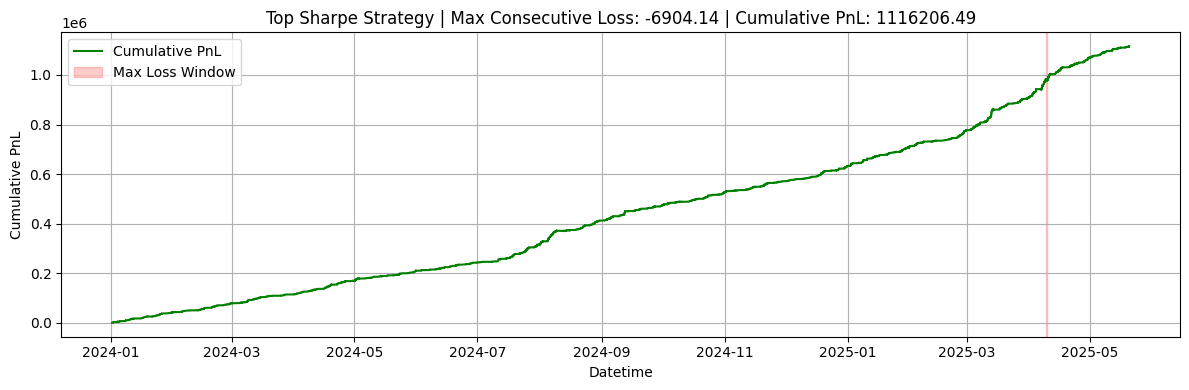

💣 Max Consecutive PnL Loss: -6904.14
📆 Period: 2025-04-09 11:45:00-04:00 → 2025-04-09 19:35:00-04:00
✅ Saved best_strategy_results.csv


In [34]:
best_result = None

def compute_max_consecutive_loss(df):
    """
    Calculates the worst cumulative loss (drawdown) from any starting point.
    """
    pnl_series = df['pnl'].values
    max_loss = 0.0
    start_idx = 0
    end_idx = 0

    for i in range(len(pnl_series)):
        cumulative = 0.0
        for j in range(i, len(pnl_series)):
            cumulative += pnl_series[j]
            if cumulative < max_loss:
                max_loss = cumulative
                start_idx = i
                end_idx = j

    return max_loss, df['entry_time'].iloc[start_idx], df['entry_time'].iloc[end_idx]


for r in all_results:
    df = r['results'].copy()
    df = df.sort_values(by='entry_time')
    df['cumulative_pnl'] = df['pnl'].cumsum()

    if (
        df['cumulative_pnl'].iloc[-1] > 0 and
        r['sharpe'] > 1 and
        r['trades'] > 1 and
        r['win_rate'] > 0.001 and
        r['profit_factor'] > 0.01 and
        r['expectancy'] > 0.01 and
        r['pnl'] > 100
    ):
        if best_result is None or r['sharpe'] > best_result['sharpe']:
            best_result = r.copy()
            best_result['cumulative_pnl'] = df['cumulative_pnl']
            best_result['entry_time'] = df['entry_time']

            # === Calculate max drawdown (largest PnL loss from peak)
            cumulative = df['cumulative_pnl']
            rolling_max = cumulative.cummax()
            drawdowns = cumulative - rolling_max
            max_drawdown = drawdowns.min()  # Most negative drop
            max_drawdown_start = rolling_max[drawdowns.idxmin()]
            best_result['max_drawdown'] = max_drawdown

# === Plot the best one ===
# === After determining best_result
if best_result:
    df = best_result['results'].copy()
    df = df.sort_values(by='entry_time')
    df['cumulative_pnl'] = df['pnl'].cumsum()

    max_loss, loss_start, loss_end = compute_max_consecutive_loss(df)

    # === Plot
    plt.figure(figsize=(12, 4))
    plt.plot(df['entry_time'], df['cumulative_pnl'], label='Cumulative PnL', color='green')
    plt.axvspan(loss_start, loss_end, color='red', alpha=0.2, label='Max Loss Window')
    plt.title(f"Top Sharpe Strategy | Max Consecutive Loss: {max_loss:.2f} | Cumulative PnL: {best_result['pnl']:.2f}")
    plt.xlabel("Datetime")
    plt.ylabel("Cumulative PnL")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"💣 Max Consecutive PnL Loss: {max_loss:.2f}")
    print(f"📆 Period: {loss_start} → {loss_end}")
    best_result['results'].to_csv("best_strategy_results.csv", index=False)
    print("✅ Saved best_strategy_results.csv")
else:
    print("❌ No strategy met the conditions.")
